-5
Upper Outer Coil force =  -0.6817623672688435 Lower Outer Coil force =  -0.4870322636981279 Magnet force =  1.170718795413209
-4
Upper Outer Coil force =  -0.6701706641534665 Lower Outer Coil force =  -0.5310043044567581 Magnet force =  1.203912149201433
-3
Upper Outer Coil force =  -0.6533889997100438 Lower Outer Coil force =  -0.573562212770163 Magnet force =  1.228602739784552
-2
Upper Outer Coil force =  -0.6314063165806884 Lower Outer Coil force =  -0.613928063259453 Magnet force =  1.244582383896555
-1
Upper Outer Coil force =  -0.6048967853039607 Lower Outer Coil force =  -0.6513160209085217 Magnet force =  1.258932754734441
0
Upper Outer Coil force =  -0.5750597926917473 Lower Outer Coil force =  -0.6851230808907033 Magnet force =  1.2621704908938
1
Upper Outer Coil force =  -0.5404761649207538 Lower Outer Coil force =  -0.7157245162030189 Magnet force =  1.255380502745576
2
Upper Outer Coil force =  -0.5029903844485687 Lower Outer Coil force =  -0.7418480850256824 Magnet fo

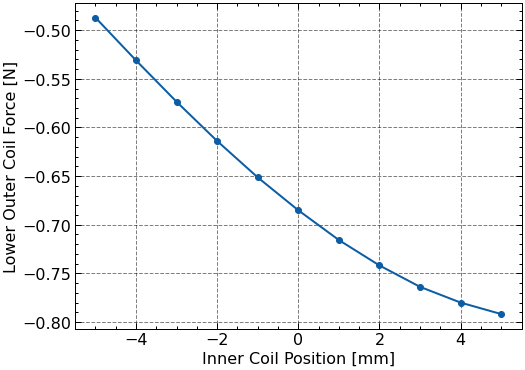

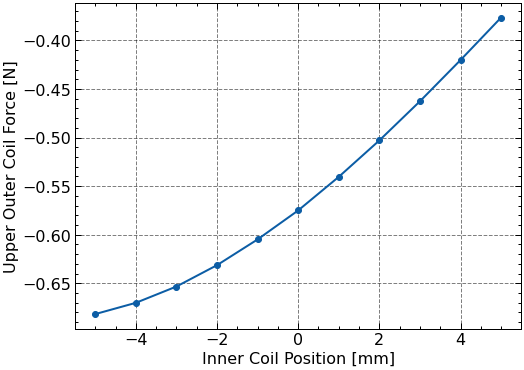

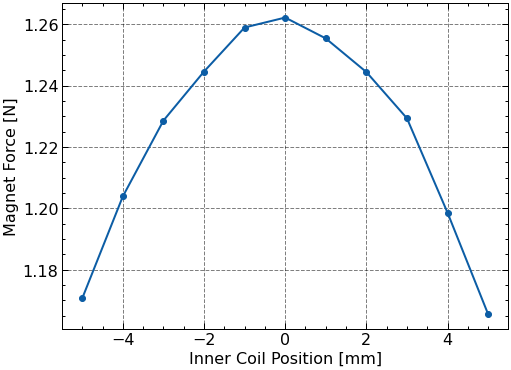

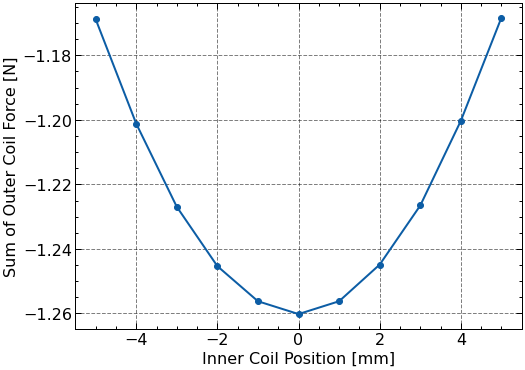

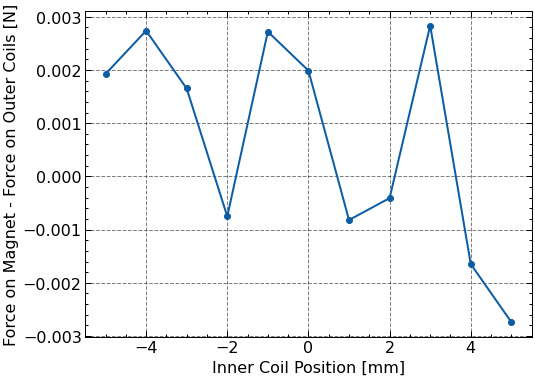

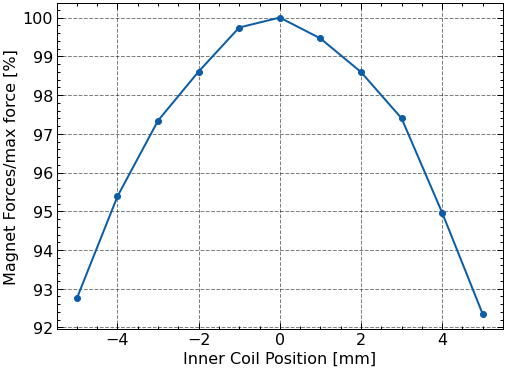

Fitted parameters of function: [-3.70994673e-03 -4.41147741e-04  1.26094261e+00]
[1.1707188  1.20391215 1.22860274 1.24458238 1.25893275 1.26217049
 1.2553805  1.24442961 1.22936123 1.19862082 1.16556308]


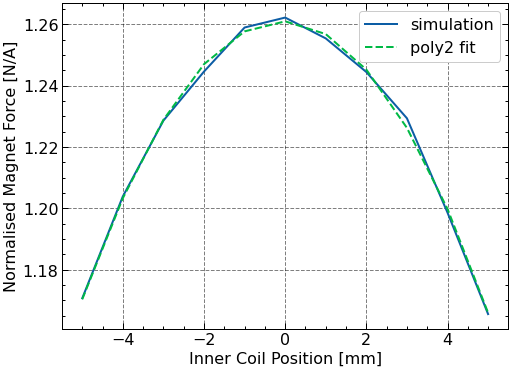

[ 0.00031912  0.0005641  -0.00027379 -0.00240273  0.00125895  0.00122788
 -0.00141101 -0.00079091  0.00313158 -0.00119805 -0.00042513]


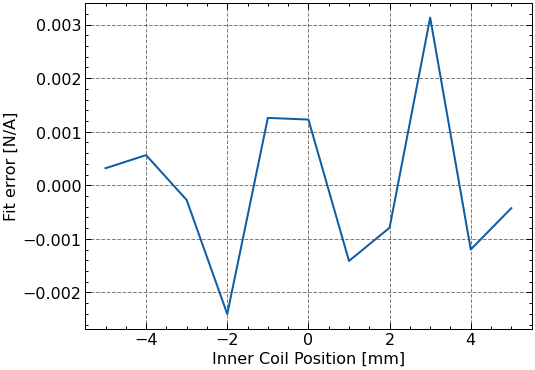

[0.02725818 0.04685538 0.02228476 0.19305536 0.100001   0.09728342
 0.11239709 0.06355626 0.25473251 0.09995247 0.03647383]


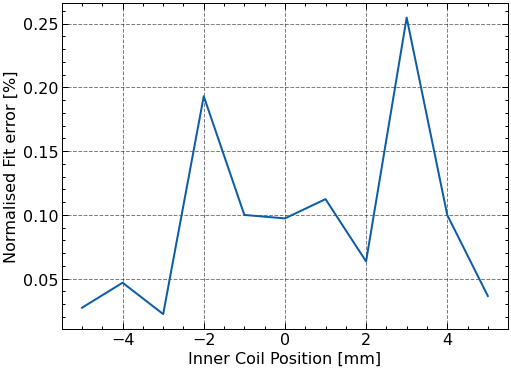

In [4]:
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt
import shutil
# The package must be initialized with the openfemm command.
femm.openfemm()

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

outputfile = 'LVDT_10kHz_20mA_31AWG_10mm_6_7_7.out'
NSteps = 10
StepSize = 1
InnCoil_Offset = -5

class Sensortype():
    def __init__(self, InnCoilCurrent, Simfreq, OutCoilCurrent):
        self.InnCoilCurrent = InnCoilCurrent
        self.Simfreq = Simfreq
        self.OutCoilCurrent = OutCoilCurrent

    def para(self):
        return [self.InnCoilCurrent, self.Simfreq, self.OutCoilCurrent]

sensor = Sensortype(0, 0, 1)

femm.mi_probdef(sensor.para()[1], 'millimeters', 'axi', 1.0e-10)

class Wiretype():
    def __init__(self, outcoil_material, inncoil_material):
        self.outcoil_material = outcoil_material
        self.inncoil_material = inncoil_material

    def prop31(self):
        return [0.2261, 0.0190, "31 AWG"]

    def prop32(self):
        return [0.2032, 0.0178, "32 AWG"]

    def mag_mat(self):
        mat = "N40"
        return mat

wire = Wiretype("31 AWG", "31 AWG")

class Geometry():
    def __init__(self, inn_ht, inn_rad, inn_layers, inn_dist, out_ht, out_rad, out_layers, out_dist, mag_len, mag_dia, ver_shi):

        self.inn_ht = inn_ht
        self.inn_rad = inn_rad
        self.inn_layers = inn_layers
        self.inn_dist = inn_dist
        self.out_ht = out_ht
        self.out_rad = out_rad
        self.out_layers = out_layers
        self.out_dist = out_dist
        self.mag_len = mag_len
        self.mag_dia = mag_dia
        self.ver_shi = ver_shi

    def inncoil(self):
        return [self.inn_ht, self.inn_rad, self.inn_layers, self.inn_dist]

    def outcoil(self):
        return [self.out_ht, self.out_rad, self.out_layers, self.out_dist]

    def mag(self):
        return [self.mag_len, self.mag_dia, self.ver_shi]

geo = Geometry(inn_ht = 24, inn_rad = 9, inn_layers = 6, inn_dist = 0, out_ht = 13.5, out_rad = 20, out_layers = 7, out_dist = 28.5, mag_len = 40, mag_dia = 10, ver_shi = 0)

class Position():
    def __init__(self):
        pass

    def inncoil(self):
        InnCoil_OutRadius = geo.inncoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.inncoil()[2])
        InnCoil_Lowend = (geo.inncoil()[3] - geo.inncoil()[0]) / 2
        InnCoil_Uppend = InnCoil_Lowend + geo.inncoil()[0]
        InnCoil_NrWind_p_Layer = (geo.inncoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        InnCoil_NrWindings = InnCoil_NrWind_p_Layer * geo.inncoil()[2]
        InnCoil_Circuit = "InnCoil_Circuit"
        return [InnCoil_OutRadius, InnCoil_Lowend, InnCoil_Uppend, InnCoil_NrWind_p_Layer, InnCoil_NrWindings,
                InnCoil_Circuit]

    def upp_outcoil(self):
        UppOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        UppOutCoil_LowEnd = (geo.outcoil()[3] - geo.outcoil()[0]) / 2
        UppOutCoil_UppEnd = UppOutCoil_LowEnd + geo.outcoil()[0]
        UppOutCoil_NrWind_p_Layer = (geo.outcoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        UppOutCoil_NrWindings = UppOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        UppOutCoil_Circuit = "UppOutCoil_Circuit"
        return [UppOutCoil_OutRadius, UppOutCoil_LowEnd, UppOutCoil_UppEnd, UppOutCoil_NrWind_p_Layer,
                UppOutCoil_NrWindings, UppOutCoil_Circuit]

    def low_outcoil(self):
        LowOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        LowOutCoil_UppEnd = -1 * ((geo.outcoil()[3] - geo.outcoil()[0]) / 2)
        LowOutCoil_LowEnd = LowOutCoil_UppEnd - geo.outcoil()[0]
        LowOutCoil_NrWind_p_Layer = (LowOutCoil_UppEnd - LowOutCoil_LowEnd) / (
                    wire.prop31()[0] + wire.prop31()[1] * 2)
        LowOutCoil_NrWindings = LowOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        LowOutCoil_Circuit = "LowOutCoil_Circuit"
        return [LowOutCoil_OutRadius, LowOutCoil_UppEnd, LowOutCoil_LowEnd, LowOutCoil_NrWind_p_Layer,
                LowOutCoil_NrWindings, LowOutCoil_Circuit]

    def magnet(self):
        Magnet_UppEnd = geo.mag()[0] / 2 + geo.mag()[2]
        Magnet_LowEnd = -geo.mag()[0] / 2 + geo.mag()[2]
        Magnet_Radius = geo.mag()[1] / 2
        return [Magnet_UppEnd, Magnet_LowEnd, Magnet_Radius]

position = Position()

class Length():
    def __init__(self):
        pass

    def inncoil(self):
        InnCoil_TotalWire = 0
        for i in range(0, geo.inncoil()[2]):
            # circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
            circ = 2 * np.pi * (geo.inncoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            InnCoil_TotalWire += circ * position.inncoil()[3]
        print("Total length of wire (mm):", InnCoil_TotalWire)
        print("\n")
        return InnCoil_TotalWire

    def upp_outcoil(self):
        UppOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):
            # circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul))
            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            UppOutCoil_TotalWire += circ * position.upp_outcoil()[3]
        print("Total length of wire (mm):", UppOutCoil_TotalWire)
        print("\n")
        return UppOutCoil_TotalWire

    def low_outcoil(self):
        LowOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):
            # circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            LowOutCoil_TotalWire += circ * position.low_outcoil()[3]
        print("Total length of wire (mm):", LowOutCoil_TotalWire)
        print("\n")
        return LowOutCoil_TotalWire

length = Length()

# InnerCoil Structure
femm.mi_drawrectangle(geo.inncoil()[1], position.inncoil()[2], position.inncoil()[0], position.inncoil()[1])
femm.mi_addcircprop(position.inncoil()[5], sensor.para()[0], 1)

if wire.inncoil_material == "31 AWG":
    femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
if wire.inncoil_material == "32 AWG":
    femm.mi_getmaterial(wire.inncoil_material)

femm.mi_clearselected()
femm.mi_selectrectangle(geo.inncoil()[1], position.inncoil()[2], position.inncoil()[0], position.inncoil()[1], 4)
femm.mi_setgroup(1)
femm.mi_clearselected()
femm.mi_addblocklabel(geo.inncoil()[1] + wire.prop31()[1], position.inncoil()[1] + (geo.inncoil()[0] / 2))
femm.mi_selectlabel(geo.inncoil()[1] + wire.prop31()[1], position.inncoil()[1] + (geo.inncoil()[0] / 2))
femm.mi_setblockprop(wire.prop31()[2], 1, 0, position.inncoil()[5], 0, 1, position.inncoil()[4])
femm.mi_clearselected()

# UpperOutCoil Structure
femm.mi_drawrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                      position.upp_outcoil()[1])
femm.mi_addcircprop(position.upp_outcoil()[5], sensor.para()[2], 1)

if wire.outcoil_material == "31 AWG":
    femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
if wire.outcoil_material == "32 AWG":
    femm.mi_getmaterial(wire.inncoil_material)

femm.mi_clearselected()
femm.mi_selectrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                        position.upp_outcoil()[1], 4)
femm.mi_setgroup(3)
femm.mi_clearselected()
femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop31()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
femm.mi_selectlabel(geo.outcoil()[1] + wire.prop31()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
femm.mi_setblockprop(wire.prop31()[2], 0, 0.1, position.upp_outcoil()[5], 0, 3, position.upp_outcoil()[4])
femm.mi_clearselected()

# LowerOutCoil Structure
femm.mi_drawrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                      position.low_outcoil()[2])
femm.mi_addcircprop(position.low_outcoil()[5], -sensor.para()[2], 1)

if wire.outcoil_material == "31 AWG":
    femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
if wire.outcoil_material == "32 AWG":
    femm.mi_getmaterial(wire.inncoil_material)

femm.mi_clearselected()
femm.mi_selectrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                        position.low_outcoil()[2], 4)
femm.mi_setgroup(4)
femm.mi_clearselected()
femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop31()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
femm.mi_selectlabel(geo.outcoil()[1] + wire.prop31()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
femm.mi_setblockprop(wire.prop31()[2], 0, 0.1, position.low_outcoil()[5], 0, 4, position.low_outcoil()[4])
femm.mi_clearselected()

# Magnet Structure
femm.mi_drawrectangle(0, position.magnet()[0], position.magnet()[2], position.magnet()[1])
femm.mi_getmaterial(wire.mag_mat())
femm.mi_clearselected()
femm.mi_selectrectangle(0, position.magnet()[0], position.magnet()[2], position.magnet()[1], 4)
femm.mi_setgroup(2)
femm.mi_clearselected()
femm.mi_addblocklabel(position.magnet()[2] * 0.5, position.magnet()[1] + (geo.mag()[0] * 0.5))
femm.mi_selectlabel(position.magnet()[2] * 0.5, position.magnet()[1] + (geo.mag()[0] * 0.5))
femm.mi_setblockprop(wire.mag_mat(), 0, 0.1, "", 90, 2, 0)
femm.mi_clearselected()

# AirSurrounding Structure
AirSpaceRadius_1 = 100
AirSpaceRadius_2 = 300
BC_Name = "Outside"
BC_Group = 10
# Airspace1
femm.mi_drawline(0, AirSpaceRadius_1, 0, -AirSpaceRadius_1)
femm.mi_drawarc(0, -AirSpaceRadius_1, 0, AirSpaceRadius_1, 180, 2)
femm.mi_getmaterial("Air")
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
femm.mi_selectlabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
femm.mi_setblockprop("Air", 0, 0.5, '', 0, 0, 0)
femm.mi_clearselected()
# Airspace2
femm.mi_drawline(0, AirSpaceRadius_2, 0, -AirSpaceRadius_2)
femm.mi_drawarc(0, -AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
femm.mi_getmaterial("Air")
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
femm.mi_selectlabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
femm.mi_setblockprop("Air", 1, 0, '', 0, 0, 0)
femm.mi_clearselected()
# Boundary properties
femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
femm.mi_clearselected()
femm.mi_selectarcsegment(0, AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
femm.mi_clearselected()

UppOutCoil_Forces = np.zeros(NSteps+1)
LowOutCoil_Forces = np.zeros(NSteps+1)
Magnet_Forces = np.zeros(NSteps+1)
InnCoil_Positions = np.zeros(NSteps+1)
MetaData = np.zeros(NSteps+1)

femm.mi_selectgroup(1)
femm.mi_selectgroup(2)
femm.mi_movetranslate(0, InnCoil_Offset)
femm.mi_clearselected()

for i in range(0,NSteps+1):

    print(InnCoil_Offset + StepSize*i)
    InnCoil_Positions[i] = InnCoil_Offset + StepSize*i

    # Now, the finished input geometry can be displayed.
    #femm.mi_zoomnatural()
    femm.mi_zoom(-2,-50,50,50)
    femm.mi_refreshview()

    # We have to give the geometry a name before we can analyze it.
    femm.mi_saveas('RevLVDT_VC_ETpf_LIP.fem')

    # Now,analyze the problem and load the solution when the analysis is finished
    femm.mi_analyze()
    femm.mi_loadsolution()

    if NSteps == 0:
        femm.mo_showdensityplot(1, 0, 0.0001, 1.0E-9, "bmag")
        femm.mo_zoom(-2,-50,50,50)
        femm.mo_refreshview()

    femm.mo_groupselectblock(3)
    UppOut_Force19 = femm.mo_blockintegral(19)
    femm.mo_clearblock()

    femm.mo_groupselectblock(4)
    LowOut_Force19 = femm.mo_blockintegral(19)
    femm.mo_clearblock()

    femm.mo_groupselectblock(2)
    Magn_Force19 = femm.mo_blockintegral(19)
    femm.mo_clearblock()

    print("Upper Outer Coil force = ", UppOut_Force19, "Lower Outer Coil force = ", LowOut_Force19, "Magnet force = ", Magn_Force19)
    UppOutCoil_Forces[i] = UppOut_Force19
    LowOutCoil_Forces[i] = LowOut_Force19
    Magnet_Forces[i] = Magn_Force19


    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, StepSize)
    femm.mi_clearselected()

print(InnCoil_Positions)
print(UppOutCoil_Forces)
print(LowOutCoil_Forces)
print(Magnet_Forces)

if NSteps > 2:
   MetaData[0] = NSteps
   MetaData[1] = StepSize
   MetaData[2] = sensor.para()[2]
   np.savetxt(outputfile, (InnCoil_Positions, UppOutCoil_Forces, LowOutCoil_Forces, Magnet_Forces, MetaData))

plt.style.use(['science','grid','notebook'])

plt.plot(InnCoil_Positions, LowOutCoil_Forces, 'o-')
plt.ylabel('Lower Outer Coil Force [N]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("low for.png")
#shutil.move("low for.png", r"<path>")
plt.show()

plt.plot(InnCoil_Positions, UppOutCoil_Forces, 'o-')
plt.ylabel('Upper Outer Coil Force [N]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("upp for.png")
#shutil.move("upp for.png", r"<path>")
plt.show()

plt.plot(InnCoil_Positions, Magnet_Forces, 'o-')
plt.ylabel('Magnet Force [N]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("mf.png")
#shutil.move("mf.png", r"<path>")
plt.show()

plt.plot(InnCoil_Positions, LowOutCoil_Forces + UppOutCoil_Forces,'o-')
plt.ylabel('Sum of Outer Coil Force [N]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("outsum.png")
#shutil.move("outsum.png", r"<path>")
plt.show()

plt.plot(InnCoil_Positions, Magnet_Forces - abs(LowOutCoil_Forces + UppOutCoil_Forces),'o-')
plt.ylabel('Force on Magnet - Force on Outer Coils [N]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("mf - inn for.png")
#shutil.move("mf - inn for.png", r"<path>")
plt.show()

plt.plot(InnCoil_Positions, Magnet_Forces/max(Magnet_Forces)*100, 'o-')
plt.ylabel('Magnet Forces/max force [%]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("nmf.png")
#shutil.move("nmf.png", r"<path>")
plt.show()

def polyfunc(x, a, b, c):
    return a*x**2 + b*x + c

Norm_Magnet_Forces = Magnet_Forces/sensor.para()[2]
optimizedParameters, pcov = opt.curve_fit(polyfunc, InnCoil_Positions, Norm_Magnet_Forces)
print("Fitted parameters of function:", optimizedParameters)
fitted_Norm_Magnet_Forces = polyfunc(InnCoil_Positions, *optimizedParameters)
print(Norm_Magnet_Forces)

plt.plot(InnCoil_Positions, Norm_Magnet_Forces, label="simulation")
plt.plot(InnCoil_Positions, fitted_Norm_Magnet_Forces, '--', label="poly2 fit")
plt.ylabel('Normalised Magnet Force [N/A]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
#plt.savefig("fit for.png")
#shutil.move("fit for.png", r"<path>")
plt.show()

print(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)
plt.plot(InnCoil_Positions, Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)
plt.ylabel('Fit error [N/A]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("fit err.png")
#shutil.move("fit err.png", r"<path>")
plt.show()

print((abs(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)/abs(Norm_Magnet_Forces))*100)
plt.plot(InnCoil_Positions, abs(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)/abs(Norm_Magnet_Forces)*100)
plt.ylabel('Normalised Fit error [%]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("norfit.png")
#shutil.move("norfit.png", r"<path>")
#plt.ylim(0.0,0.01)
plt.show()

